This example was introduced in [BTV03] showing that there exists values of $\alpha$ for which the finiteness conjecture does not hold, that is, there is no $w = \sigma_1, \ldots, \sigma_k$ such that
$\sqrt[k]{\rho(A_{\sigma_k} \cdots A_{\sigma_1})}$ is equal to the JSR (such product is called a Spectral Maximizing Product (s.m.p.)).
Let $J_w \subseteq [0, 1]$ be the set of $\alpha$ such that $w$ is a s.m.p.
They show that for two words $u, v$ we have either $J_u = J_v$ (in which case $uuu\cdots$ and $vvv\cdots$ are identical up to a different prefix) or $J_u \cap J_v = \emptyset$.
In fact, let $\beta = \log(\alpha)$, since the function $h_w(\beta) = \log(\sqrt[|w|]{\rho(A_w)}) = \frac{1}{|w|}(\log(\rho(A_w)) + |w|_1 \beta)$ is affine in $\beta$, $J_u$ and $J_v$ can only be either equal, with empty intersection or with intersection equal to one of their two boundary points.
So [BTV03] excludes this last case.
The authors also mention that
$$ J_{0} = \{0\} \quad \text{ and } \quad J_1 = \emptyset. $$

The, in [Section V, GZ05], the authors show that
$$J_{10} = [4/5, 1] \quad \text{ and } \quad J_{100} \approx [0.5734, 0.7444] $$

It was then shown in [Section 6, GZ08] that for
$$J_{10010} =
\left[\frac{222924 - 23339 \sqrt{6}}{221184}, \frac{36864(222924 - 23339 \sqrt{6})}{7737809375} \right]
\approx [0.74940031328298342722, 0.789681582229248583974]$$

It was then proved in [HMST11] that the finiteness property does not hold for
$$\alpha = 0.749326546330367557943961948091344672091327370236064317358024...$$

[BTV03] V. D. Blondel, J. Theys and A. A. Vladimirov,
*An elementary counterexample to the finiteness conjecture*,
SIAM Journal on Matrix Analysis and Applications, **2003**. 24, 963-970.

[GZ05] N. Guglielmi and M. Zennaro.
*Polytope norms and related algorithms for the computation of the joint spectral radius*.
44th IEEE Conference on Decision and Control, and European Control Conference, **2005**, pp. 3007-3012.

[GZ08] N. Guglielmi and M. Zennaro.
*An algorithm for finding extremal polytope norms of matrix families*.
Linear Algebra and its Applications, **2008**, 428(10), 2265-2282.

[HMST11] K. G. Hare, I. D Morris, N. Sidorov and J. Theys,
*An explicit counterexample to the Lagarias–Wang finiteness conjecture*.
Advances in Mathematics, **2011**, 226(6), 4667-4701.

In [1]:
using HybridSystems
using StaticArrays
A0 = @SMatrix [1 1; 0 1]
A1 = @SMatrix [1 0; 1 1]
A(α) = discreteswitchedsystem([A0, α * A1])
s1 = A(1.0)

Hybrid System with automaton OneStateAutomaton(2)

In [8]:
using SwitchOnSafety
using Profile
Profile.clear()
@time quicklb(s1, 15)

  0.055866 seconds (700.24 k allocations: 38.566 MiB, 21.95% gc time)


1.6060434946016988

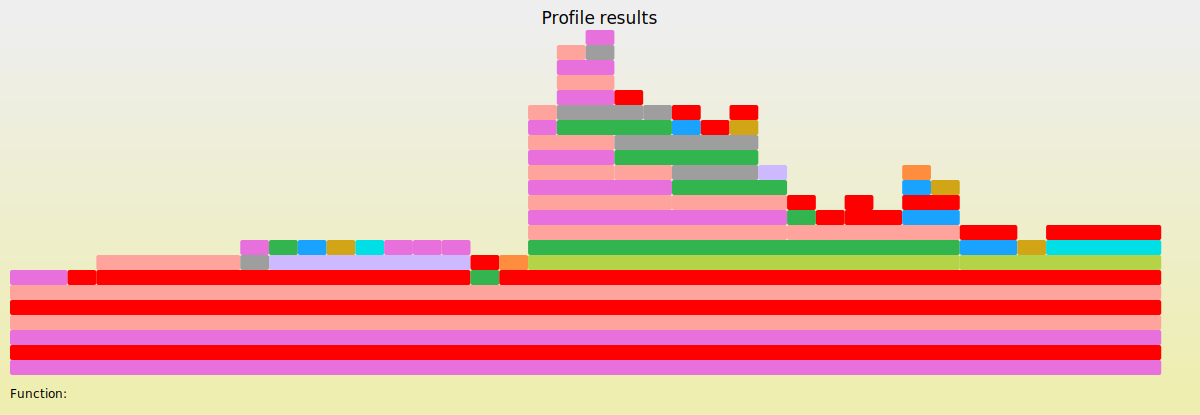

In [6]:
using ProfileView
ProfileView.view()

In [9]:
using SwitchOnSafety
struct H{S}
    smp::SwitchOnSafety.DiscretePeriodicSwitching{S, HybridSystems.OneStateTransition}
    constant::Float64 # log(ρ(A_w))
    coefficient::Int  # |w|_1
    k::Int            # |w|
end
function H(w::Int, k)
    smp = periodicswitching(s1, [HybridSystems.OneStateTransition(((w >> i) & 1) + 1) for i in 0:(k-1)])
    constant = log(smp.growthrate) * k
    coefficient = count(tr -> tr.σ == 2, smp.period)
    H{typeof(s1)}(smp, constant, coefficient, k)
end
binstr(smp::SwitchOnSafety.DiscretePeriodicSwitching) = join(map(tr -> tr.σ - 1, smp.period))
binstr(h::H) = binstr(h.smp)
heval(h::H, β::Float64) = (h.constant + h.coefficient * β) / h.k
function intersect(h1::H, h2::H)
    if h1.coefficient/h1.k == h2.coefficient/h2.k
        return -Inf
    else
        -(h1.constant/h1.k - h2.constant/h2.k) / (h1.coefficient/h1.k - h2.coefficient/h2.k)
    end
end
function hs(K)
    h = Vector{H{typeof(s1)}}(undef, (1 << (K+1)) - 2)
    j = 0
    for k in 1:K
        for w in 0:((1 << k) - 1)
            j += 1
            h[j] = H(w, k)
        end
    end
    return h
end

hs (generic function with 1 method)

In [10]:
hs(1)

2-element Array{H{HybridSystem{OneStateAutomaton,MathematicalSystems.DiscreteIdentitySystem,MathematicalSystems.LinearDiscreteSystem{Float64,SArray{Tuple{2,2},Float64,2,4}},AutonomousSwitching}},1}:
 H{HybridSystem{OneStateAutomaton,MathematicalSystems.DiscreteIdentitySystem,MathematicalSystems.LinearDiscreteSystem{Float64,SArray{Tuple{2,2},Float64,2,4}},AutonomousSwitching}}(PSW(1.0, [1]), 0.0, 0, 1)
 H{HybridSystem{OneStateAutomaton,MathematicalSystems.DiscreteIdentitySystem,MathematicalSystems.LinearDiscreteSystem{Float64,SArray{Tuple{2,2},Float64,2,4}},AutonomousSwitching}}(PSW(1.0, [2]), 0.0, 1, 1)

In [11]:
function hs_β_smp(K)
    hs = Main.hs(K)
    smp0 = 1
    for i in 2:length(hs)
        if heval(hs[i], 0.0) ≈ heval(hs[smp0], 0.0)
            if hs[i].coefficient / hs[i].k < hs[smp0].coefficient / hs[i].k
                smp0 = i
            end
        else
            if heval(hs[i], 0.0) > heval(hs[smp0], 0.0)
                smp0 = i
            end
        end
    end
    smp = [smp0]
    β = [0.0]
    while smp[end] != 1
        smpnext = 1
        function obj(h::H)
            i = intersect(h, hs[smp[end]])
            if i > β[end] || i ≈ β[end]
                return -Inf
            end
            return i
        end
        for i in 2:length(hs)
            o = obj(hs[i])
            if o ≈ obj(hs[smpnext])
                if hs[i].coefficient / hs[i].k < hs[smp0].coefficient / hs[i].k
                    smpnext = i
                end
            else
                if o < obj(hs[smpnext])
                    smpnext = i
                end
            end
        end
        j = argmax(obj.(hs))
        push!(β, obj(hs[j]))
        @assert β[end] < β[end-1]
        push!(smp, j)
    end
    return hs, β, smp
end

hs_β_smp (generic function with 1 method)

In [12]:
struct J{S}
    h::H{S}
    αmin::Float64
    αmax::Float64
end
function js(K)
    hs, β, smp = hs_β_smp(K)
    @assert length(β) == length(smp)
    return map(i -> begin
        αmax = exp(β[i])
        if i == length(β)
            αmin = 0.0
        else
            αmin = exp(β[i+1])
        end
        return J(hs[smp[i]], αmin, αmax)
    end, length(β):-1:1)
end
function Base.show(io::IO, j::J)
    println(io, " smp: ", binstr(j.h))
    println(io, "From: ", j.αmin)
    println(io, "  To: ", j.αmax)
end

In [69]:
using Plots
pyplot()
function plot_h(K)
    hs, β, smp = hs_β_smp(K)
    @show β
    plot()
    for i in 1:length(β)
        βnext = i == length(β) ? β[i] - 1 : β[i + 1]
        h = hs[smp[i]]
        plot!([β[i], βnext], [heval(h, β[i]), heval(h, βnext)], label=binstr(h))
    end
    plot!()
end
function plot_he(K)
    hs, β, smp = hs_β_smp(K)
    @show exp.(β)
    plot(xlim = (0.0, 1.0))
    for i in 1:length(β)
        βnext = i == length(β) ? β[i] - 1 : β[i + 1]
        h = hs[smp[i]]
        plot!([exp(β[i]), exp(βnext)], [heval(h, β[i]), heval(h, βnext)], label=binstr(h))
    end
    plot!()
end

plot_he (generic function with 1 method)

β = [0.0, -0.22323, -0.225514, -0.236048, -0.28852, -0.294897, -0.55617, -0.558579, -0.581489, -0.777487, -0.789908, -0.952247, -1.09331, -1.21499, -1.32234, -1.41858, -2.38953]


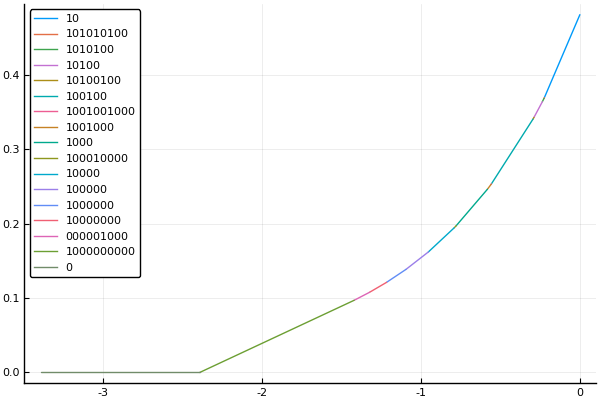

In [72]:
plot_h(10)

exp.(β) = [1.0, 0.796718, 0.746391, 0.566979, 0.457029, 0.171573]
  0.030320 seconds (38.72 k allocations: 1.984 MiB)


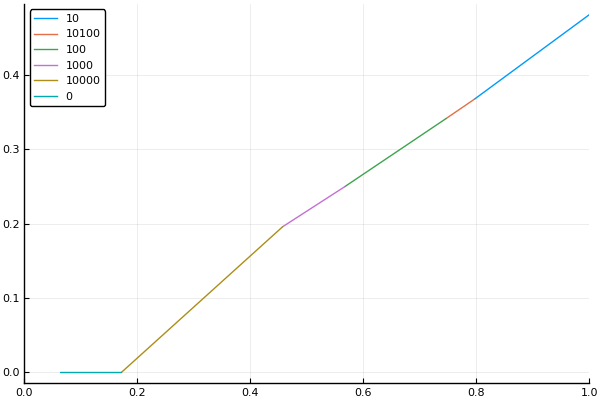

In [92]:
@time plot_he(5)

In [25]:
@time jw = js(17)

 11.744915 seconds (221.02 M allocations: 4.333 GiB, 10.01% gc time)


49-element Array{J{HybridSystem{OneStateAutomaton,MathematicalSystems.DiscreteIdentitySystem,MathematicalSystems.LinearDiscreteSystem{Float64,Array{Float64,2}},AutonomousSwitching}},1}:
  smp: 0
From: 0.0
  To: 0.055728090000841266
                                
  smp: 10000000000000000
From: 0.055728090000841266
  To: 0.14820476232456434

  smp: 1000000000000000
From: 0.14820476232456434
  To: 0.15684071070742764
  
  smp: 100000000000000
From: 0.15684071070742764
  To: 0.16655893011101977
   
  smp: 10000000000000
From: 0.16655893011101977
  To: 0.1775797790180443
     
  smp: 1000000000000
From: 0.1775797790180443
  To: 0.19018895991311285
      
  smp: 100000000000
From: 0.19018895991311285
  To: 0.2047642388309615
       
  smp: 10000000000
From: 0.2047642388309615
  To: 0.2218167968034444
         
  smp: 1000000000
From: 0.2218167968034444
  To: 0.2420577888471559
          
  smp: 000001000
From: 0.2420577888471559
  To: 0.2661938350175111
           
  smp: 10000000100000000

In [29]:
jw[38].h.smp

PSW(1.574674, [2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1])

In [26]:
jw[38]

 smp: 1010010100100
From: 0.7493264930942595
  To: 0.7494000219027658


In [13]:
α∞ = 0.749326546330367557943961948091344672091327370236064317358024
s∞ = A(α∞)

Hybrid System with automaton OneStateAutomaton(2)

In [14]:
typeof(s∞)

HybridSystem{OneStateAutomaton,MathematicalSystems.DiscreteIdentitySystem,MathematicalSystems.LinearDiscreteSystem{Float64,SArray{Tuple{2,2},Float64,2,4}},AutonomousSwitching}

In [15]:
function show_smp(smp)
    println("   SMP: ", binstr(smp))
    println("Length: ", length(smp.period))
    println("Growth: ", smp.growthrate)
end

show_smp (generic function with 1 method)

In [44]:
show_smp(periodicswitching(s∞, jw[38].h.smp.period))

   SMP: 1010010100100
Length: 13
Growth: 1.4092472220583443


In [18]:
using SwitchOnSafety
sosdata(s∞).smp = nothing
@time quicklb(s∞, 1:23)
show_smp(sosdata(s∞).smp)

 16.904939 seconds (326.30 M allocations: 19.173 GiB, 20.25% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [19]:
@time quicklb(s∞, 24)
show_smp(sosdata(s∞).smp)

 22.579059 seconds (505.57 M allocations: 27.854 GiB, 22.94% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [20]:
@time quicklb(s∞, 25)
show_smp(sosdata(s∞).smp)

 37.700757 seconds (639.70 M allocations: 39.097 GiB, 21.99% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [21]:
@time quicklb(s∞, 26)
show_smp(sosdata(s∞).smp)

 80.704443 seconds (1.45 G allocations: 86.021 GiB, 22.12% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [22]:
@time quicklb(s∞, 27)
show_smp(sosdata(s∞).smp)

158.086423 seconds (2.86 G allocations: 169.739 GiB, 22.24% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [3]:
using MathOptInterfaceMosek
using JuMP
factory = with_optimizer(MosekOptimizer, QUIET=true);

In [4]:
using SwitchOnSafety
sosdata(s∞).lb = 0.0
@time lb2, ub2 = soslyapb(s∞, 1, factory=factory, tol=4e-7, step=0.5, verbose=1)

┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.0/SwitchOnSafety/PA0qe.ji for SwitchOnSafety [4b7ae085-addf-5b2e-b0f2-71171a701510]
└ @ Base loading.jl:1187


Lower bound: 1.4264934336122035
Upper bound: 1.426493943766101
Log-diff   : 3.576278687078549e-7 ≤ 4.0e-7
 33.029037 seconds (79.62 M allocations: 3.894 GiB, 7.51% gc time)


(1.0086831802252711, 1.426493943766101)

In [42]:
@time seq = sosbuildsequence(s∞, 1, niter=100, l=4, p_0=:Primal)
@time psw = findsmp(seq)
println(binstr(psw))
println(length(psw.period))
println(psw.growthrate)

  0.020510 seconds (217.44 k allocations: 12.231 MiB, 36.55% gc time)
  0.373782 seconds (6.29 M allocations: 266.325 MiB, 14.74% gc time)
010100100101001001010
21
1.4092472220583487
